<a href="https://colab.research.google.com/github/sahiliem/colab/blob/main/paper_abstract_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning GPT-2 for Text Generation with Tensorflow

In **Casual Language Modeling** the model has to **predict the next token** in a sequence on tokens. In this way the model can actually **generate text**. In this notebook I will show how to **fine-tune GPT-2 on a custom dataset** using **Tensorflow**.

## 1. Importing Tools

Let's start by importing all the required **tools** and **libraries**. Note that we use the `TFAutoModelForCasuelLM` and `AutoTokenizer` functionalities to **automatically** load the **correct model** based on the checkpoint we well pass to the `from_pretrained()` method in the next cell.

In [ ]:
# %gist gistname: FTGPT_import.py
from transformers import TFAutoModelForCausalLM, AutoTokenizer, AdamWeightDecay, pipeline, create_optimizer
from transformers import DefaultDataCollator
import tensorflow as tf
from datasets import Dataset, DatasetDict, load_dataset
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
os.environ["TOKENIZERS_PARALLELISM"] = "false"
pio.renderers.default = 'notebook_connected'
plt.style.use('dark_background')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edoardobianchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Importing the baseline model and tokenizer

We import the **pretrained tokenizer and model**. In particular we load the **DistilGPT-2** model checkpoint. This model is obtained by **distillation** and it's **faster then the OpenAI original**. Note, that we also set the **end of sequence token** as padding token.

In [ ]:
# %gist gistname: FTGPT_load.py
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
model = TFAutoModelForCausalLM.from_pretrained("distilgpt2", pad_token_id=tokenizer.eos_token_id)

2022-10-17 17:23:56.526946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-17 17:23:56.527852: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


## 3. Importing Data

The dataset for the **fine-tuning** is hosed on the **Huggingface Hub**, and it's a subset of a bigger dataset hosted on **Kaggle**. The dataset, originally published by the **Cornell University**, contains **1.7M+ scientific papers** belonging to the **STEM category**, published on **ArXiv**. The subset on Huggingface Hub contains around **100K papers** belonging to the **Machine Learning category**. The license allows for commercial use.

The dataset contains the **titles** and the **astracts** of papers. We will fine-tune GPT-2 on the titles.

Let's start by **loading the dataset** from the Huggingface Hub.

In [ ]:
# %gist gistname: FTGPT_data.py
data = load_dataset("CShorten/ML-ArXiv-Papers", split='train')
data

Using custom data configuration CShorten--ML-ArXiv-Papers-0dcddd7fc76c9211
Reusing dataset csv (/Users/edoardobianchi/.cache/huggingface/datasets/CShorten___csv/CShorten--ML-ArXiv-Papers-0dcddd7fc76c9211/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


Dataset({
    features: ['Unnamed: 0', 'Unnamed: 0.1', 'title', 'abstract'],
    num_rows: 117592
})

**Alternatively**, if your dataset comes in CSV (or other formats), you can load it with **Pandas** and **convert it to a Dataset** with `Dataset.from_pandas()`.

In [ ]:
# %gist gistname: FTGPT_fromPandas.py
df = pd.read_csv("my.csv")
data = Dataset.from_pandas(df)

In [ ]:
# %gist gistname: FTGPT_plot.py
abstracts = [len(x.split()) for x in data["abstract"]]
px.histogram(abstracts, nbins=400, marginal="rug", labels={"value":"Article Length (words)"})

In [ ]:
from statistics import mean, mode, median
print(mode(abstracts))
print(mean(abstracts))
print(median(abstracts))

150
166.95294747942037
164.0


## 4. Split into Train and Validation Set

Next, we **split the dataset** into two subset: **train** and **validation**. We use the `train_test_split()` method for that. It is possible to **specify the partitions** with the `test_size=` parameter.

In [ ]:
# %gist gistname: FTGPT_split.py
data = data.train_test_split(shuffle = True, seed = 200, test_size=0.2)

train = data["train"]
val = data["test"]

Loading cached split indices for dataset at /Users/edoardobianchi/.cache/huggingface/datasets/CShorten___csv/CShorten--ML-ArXiv-Papers-0dcddd7fc76c9211/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-b9184d3bcb179935.arrow and /Users/edoardobianchi/.cache/huggingface/datasets/CShorten___csv/CShorten--ML-ArXiv-Papers-0dcddd7fc76c9211/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-cdcd244870560dd2.arrow


## 5. Tokenize Data with HF Tokenizer

In order to tokenize the data, we first define a **generic tokenization function**, and then we **apply this function to all the samples** by using the **`map()` functionality**.

Inside the tokenization function we use the **tokenizer** imported in the beginning. The tokenizer has some **important parameters**:
1. **The column to tokenize**, in this case "title".
2. **A padding option**. In this case "max_lenght" to pad a sequence to the maximun length specified by the max_length parameter.
3. **A truncation option**. Set to true in order to truncate sequences longer than the maximun length, specified by the max_length parameter.
4. **The max_length parameter**. Specify the maximun length of a sequence.

Please note that by default the `map()` method sends batches of 1000 samples.

In [ ]:
# %gist gistname: FTGPT_tokenize.py
# The tokenization function
def tokenization(data):
    tokens = tokenizer(data["abstract"], padding="max_length", truncation=True, max_length=300)
    return tokens

# Apply the tokenizer in batch mode and drop all the columns except the tokenization result
train_token = train.map(tokenization, batched = True, remove_columns=["title", "abstract", "Unnamed: 0", "Unnamed: 0.1"], num_proc=10)
val_token = val.map(tokenization, batched = True, remove_columns=["title", "abstract", "Unnamed: 0", "Unnamed: 0.1"], num_proc=10)

#0:   0%|          | 0/10 [00:00<?, ?ba/s]

#1:   0%|          | 0/10 [00:00<?, ?ba/s]

#2:   0%|          | 0/10 [00:00<?, ?ba/s]

#3:   0%|          | 0/10 [00:00<?, ?ba/s]

#4:   0%|          | 0/10 [00:00<?, ?ba/s]

#5:   0%|          | 0/10 [00:00<?, ?ba/s]

#6:   0%|          | 0/10 [00:00<?, ?ba/s]

#7:   0%|          | 0/10 [00:00<?, ?ba/s]

#8:   0%|          | 0/10 [00:00<?, ?ba/s]

#9:   0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#2:   0%|          | 0/3 [00:00<?, ?ba/s]

#3:   0%|          | 0/3 [00:00<?, ?ba/s]

#4:   0%|          | 0/3 [00:00<?, ?ba/s]

#5:   0%|          | 0/3 [00:00<?, ?ba/s]

#6:   0%|          | 0/3 [00:00<?, ?ba/s]

#7:   0%|          | 0/3 [00:00<?, ?ba/s]

#9:   0%|          | 0/3 [00:00<?, ?ba/s]

#8:   0%|          | 0/3 [00:00<?, ?ba/s]

## 6. Adding Labels to Train and Validation Sets

In Causual Language Modeling, the labels are the **input tokens (input_ids) right shifted**. We do not need to manually do this operation because it's **automatically done by the Huggingface transformer**. We just need to crate a label column in the datasets with a **copy of the tokens** (input_ids).

To perform this operation we use again the `map()` function. After this operation, the train and validation sets will have **three columns**: `input_ids` and `attention_mask` from the **tokenization** process, and `labels` from the `create_labels()` process.

In [ ]:
# %gist gistname: FTGPT_labels.py
# Create labels as a copy of input_ids
def create_labels(text):
    text["labels"] = text["input_ids"].copy()
    return text

# Add the labels column using map()
lm_train = train_token.map(create_labels, batched=True, num_proc=10)
lm_val = val_token.map(create_labels, batched=True, num_proc=10)

#0:   0%|          | 0/10 [00:00<?, ?ba/s]

#1:   0%|          | 0/10 [00:00<?, ?ba/s]

#2:   0%|          | 0/10 [00:00<?, ?ba/s]

#3:   0%|          | 0/10 [00:00<?, ?ba/s]

#4:   0%|          | 0/10 [00:00<?, ?ba/s]

#5:   0%|          | 0/10 [00:00<?, ?ba/s]

#7:   0%|          | 0/10 [00:00<?, ?ba/s]

#6:   0%|          | 0/10 [00:00<?, ?ba/s]

#8:   0%|          | 0/10 [00:00<?, ?ba/s]

#9:   0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#2:   0%|          | 0/3 [00:00<?, ?ba/s]

#3:   0%|          | 0/3 [00:00<?, ?ba/s]

#4:   0%|          | 0/3 [00:00<?, ?ba/s]

#5:   0%|          | 0/3 [00:00<?, ?ba/s]

#6:   0%|          | 0/3 [00:00<?, ?ba/s]

#7:   0%|          | 0/3 [00:00<?, ?ba/s]

#9:   0%|          | 0/3 [00:00<?, ?ba/s]

#8:   0%|          | 0/3 [00:00<?, ?ba/s]

## 7. Converting Train and Validation Sets to TF Datasets

Next, we need to **convert the datasets** to `tf.data.Dataset`, which **Keras can understands natively**. In this case we use the `Model.prepare_tf_dataset()` method. In respect to the `Dataset.to_tf_dataset()` method, the `Model` method can **automatically** determine **which column names to use as input**. It also provide a **default data collator** which is suitable for most tasks.

Note that we **only shuffle the train set**. The **batch size** is set to 16.

In [ ]:
# %gist gistname: FTGPT_toDataset.py
train_set = model.prepare_tf_dataset(
    lm_train,
    shuffle=True,
    batch_size=16
)

validation_set = model.prepare_tf_dataset(
    lm_val,
    shuffle=False,
    batch_size=16
)

## 8. Compiling, Fitting, and Evaluating the Model

Before fitting the model, we set up a **learning rate scheduler** and an **optimizer**. In this case we use the `ExponentialDecay` scheduler from **Keras** and the `AdamWeightDecay` optimizer from **Huggingface**. Another possibility is to use the `create_optimizer` function for a learning rate schedule. You can also use a fixed learning rate.

The **learning rate decay** is a technique that allows to start the training with a **bigger learning rate** and then **reducing it overtime**. With an **exponential decay** we lower the learning rate overtime **exponentially**.

In [ ]:
# %gist gistname: FTGPT_scheduler.py
# Setting up the learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=500,
    decay_rate=0.95,
    staircase=False)

In [ ]:
# %gist gistname: FTGPT_optimizer.py
# Setting up the optimizer - choose one!

# Fixed learning rate
optimizer = AdamWeightDecay(learning_rate=0.0005, weight_decay_rate=0.01)

# Exponential decay learning rate
optimizer = AdamWeightDecay(learning_rate=lr_schedule, weight_decay_rate=0.01)

Next, we can **compile the model**. Transformers models generally **compute loss internally** and we don't need to specify a loss parameter. In the case on **language modelling** the selected loss is **cross-entropy**.

We can also use the `jit_compile` argument to compile the model with **XLA**. XLA ensure **faster training iterations** after an initial delay at the start. For more information refer to https://www.tensorflow.org/xla.

In [ ]:
# %gist gistname: FTGPT_compile.py
model.compile(optimizer=optimizer)
model.summary()

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 81912576  
 r)                                                              
                                                                 
Total params: 81,912,576
Trainable params: 81,912,576
Non-trainable params: 0
_________________________________________________________________


At this point we can set up a **callback to the Huggingface Hub** in roder to **save our fine-tuned model**. This step is **optional** and won't change the training pahse.

In [ ]:
# %gist gistname: FTGPT_callbackHF.py
# This cell is optional
from transformers.keras_callbacks import PushToHubCallback

model_name = "GPT-2"
push_to_hub_model_id = f"{model_name}-finetuned-papers"

push_to_hub_callback = PushToHubCallback(
    output_dir="./clm_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
    hub_token="your HF token"
)

Cloning https://huggingface.co/EdBianchi/GPT-2-finetuned-papers into local empty directory.


We also set up a **callback to tensorboard**. This step is **optional**. We can then access the tensorboard dashboard by running `tensorboard --logdir tensorboard/logs/` in the terminal.

In [ ]:
# %gist gistname: FTGPT_callbackTB.py
#This cell is optional
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./tensorboard",
                                    update_freq=1,
                                    histogram_freq=1,
                                    profile_batch="2,10")

2022-10-12 16:58:00.201063: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-10-12 16:58:00.201091: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-10-12 16:58:00.201823: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [ ]:
callbacks = [push_to_hub_callback, tensorboard_callback]

Finally, we can actually **fit the model** calling the `fit()` method. We specify the **train** and **validation** set and the **number of epochs**.

In [ ]:
# %gist gistname: FTGPT_fit.py
# Fitting the model - choose one!

# Fit with callbacks
model.fit(train_set, validation_data=validation_set, epochs=1, workers=9, use_multiprocessing=True, callbacks=callbacks)

# Fit only
model.fit(train_set, validation_data=validation_set, epochs=1)

   1/5879 [..............................] - ETA: 4:50:01 - loss: 2.9112

2022-10-12 16:58:19.693563: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-10-12 16:58:19.693573: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  10/5879 [..............................] - ETA: 2:49:16 - loss: 3.1717

2022-10-12 16:58:35.238112: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-10-12 16:58:35.245831: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-10-12 16:58:35.255469: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tensorboard/plugins/profile/2022_10_12_16_58_35

2022-10-12 16:58:35.258163: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./tensorboard/plugins/profile/2022_10_12_16_58_35/Edoardos-MacBook-Pro.local.trace.json.gz
2022-10-12 16:58:35.266099: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tensorboard/plugins/profile/2022_10_12_16_58_35

2022-10-12 16:58:35.266430: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./tensorboard/plugins/profile/2022_10_12_16_58_35/Edoardos-MacBook-Pro.local.memory_profi

5879/5879 [==============================] - ETA: 0s - loss: 2.4718

2022-10-12 19:41:20.664966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5879/5879 [==============================] - 10358s 2s/step - loss: 2.4718 - val_loss: 2.2371


**Evaluate the model** and get its **cross-entropy loss** on the validation set.

In [ ]:
# %gist gistname: FTGPT_eval.py
eval_loss = model.evaluate(validation_set)

1470/1470 [==============================] - 555s 377ms/step - loss: 2.2371


Generally, the **quality of a language models** is measured in '**perplexity**'. To convert cross-entropy to perplexity, we simply **raise e to the power of the cross-entropy** loss.

In [ ]:
# %gist gistname: FTGPT_perplexity.py upload: both
print(f"Perplexity: {math.exp(eval_loss):.2f}")

Perplexity: 9.37


## 8.1. Uploading a Model to the Hub

In [ ]:
from huggingface_hub import Repository
repo = Repository(local_dir="./clm_model_save")

In [ ]:
repo.git_pull()
repo.push_to_hub(commit_message="Commit my-awesome-file to the Hub")
repo.git_push()

## 9. Generating Text Using a Pipeline

At this point, we can laverage the `pipeline` functionality provided by Huggingface to **see our model in action**. In this case we setup a **text-generation pipeline**. We specify in the pipeline the **model** and the **tokenizer**. we specify also to use **Tensorflow** and the **maximun number of tokens** (words) to generate (in addition to the initial prompt we provide).

In [ ]:
# %gist gistname: FTGPT_pipeline.py
# Setting up the pipeline
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    framework="tf",
    max_new_tokens=500
)

Once the pipeline is ready, we can **generate text from a prompt**. In this example, the prompt is *"clustering"*.

In [ ]:
# %gist gistname: FTGPT_inference.py
test_sentence = "clustering"
text_generator(test_sentence)

[{'generated_text': 'clustering can be used to extract clusterings from data points. However,\nin many real-world scenarios, data points often appear in non-Euclidean\nrelaxations, which allows different clusters to be discovered simultaneously\nwithout the need for specific optimization. In this paper, we consider a\nclass of applications where clustering methods are applied. A common example\nis that in image selection problems, we show to the optimizer that\nthe expected improvement will be obtained by minimizing the average\nperformance of the clustering method.\n  Our main contribution is a characterization of optimization problems\nwith respect to clustering methods. Specifically, we present a generalization\nof the optimal transport method for which our special bounds in terms of the\nmaximum number of clusters are derived. We apply this algorithm to\nclassification of human brain tumors, showing that it is computationally\nefficient. We show that based on our analysis of a part

## 10. Generating Text without a Pipeline

The `pipeline` is **not the only way** to use our model. In fact, we can **tokenize the prompt**, **generate the new tokens**, and **decode the tokens** to natural language. Here's how.

In [ ]:
# %gist gistname: FTGPT_inferenceNoPipeline.py
input_ids = tokenizer.encode(test_sentence, return_tensors="tf")
output = model.generate(input_ids, max_length=50)
tokenizer.decode(output[0], skip_special_tokens=True)

## 11. Using a Model from the Hub

If you used the Huggingface Model Hub callback, you can now **use your model from everywhere**. Simply pass your **chechpoint** name (Step 8, cell 4) to the `from_pretrained` method. Then you can use the model with a pipeline.

In [ ]:
# %gist gistname: FTGPT_modelFromHub.py
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_fromhub = AutoTokenizer.from_pretrained("EdBianchi/GPT-2-finetuned-papers")
model_fromhub = AutoModelForCausalLM.from_pretrained("EdBianchi/GPT-2-finetuned-papers", from_tf=True)

2022-10-30 12:38:15.061083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-30 12:38:15.061455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



All TF 2.0 model weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


In [ ]:
text_generator = pipeline(
    "text-generation",
    model=model_fromhub,
    tokenizer=tokenizer_fromhub,
    framework="tf",
    max_new_tokens=3000
)

In [ ]:
test_sentence = "the role of recommender systems"
res=text_generator(test_sentence)[0]["generated_text"].replace("\n", " ")
res

"the role of recommender systems in the real-world is still largely to be demonstrated by the lack of data and the need for data. Hence, for many recommendation systems such as Amazon or Spotify, it is necessary to provide a user knowledge of the content that has been clicked during the recommendation and provide a user knowledge of the user preferences. The previous works attempt to exploit data related to items they have clicked during an appropriate time frame. But little attention has been paid to the problem of item classification where a suitable time-frame is available for user prediction. In this paper, we propose a multi-task learning approach to address the problem of item classification. For each task, we apply the contextual cues introduced by the user, and then learn to predict the user's purchased items' interests.   Since the contexts of user preferences, we consider the feature that the user's preference (the time-frame) is present at the time of recommendation. In part


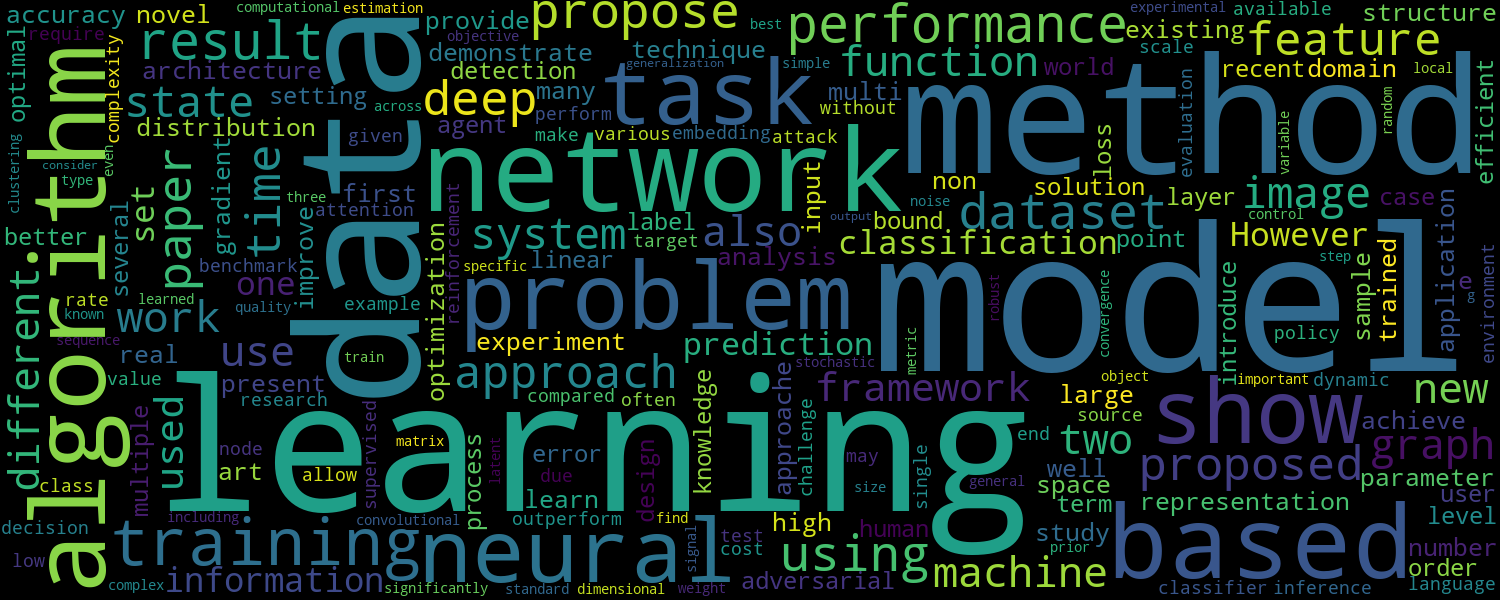

In [ ]:
allAbstracts = pd.Series(data["abstract"]).str.cat(sep=' ').replace("\n", " ")
wordcloud = WordCloud(collocations=False, 
                                width=1500, 
                                height=600, 
                                max_font_size=200,
                                stopwords=stopwords.words("english")
                            ).generate(allAbstracts)
fig = px.imshow(wordcloud, labels=dict(x="Most frequent words in all the abstracts"))
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [ ]:
# Wordcloud using Plotly
def generateWordCloud(prompt, numOfSamples, text_generator):
    stopwordsNew = stopwords.words("english")
    for x in prompt.split():
        stopwordsNew.append(x)

    texts=[]
    for x in tqdm(range(numOfSamples)):
        texts.append(text_generator(prompt)[0]["generated_text"].replace("\n", " "))
    texts = pd.Series(texts).str.cat(sep=' ')
    wordcloud = WordCloud(collocations=False, 
                                width=1500, 
                                height=600, 
                                max_font_size=200,
                                stopwords=stopwordsNew
                            ).generate(texts)
    fig = px.imshow(wordcloud, labels=dict(x="Most frequent words in the " +str(numOfSamples)+ " AI-generated text samples. Prompt: "+ prompt +""))
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.show()

100%|██████████| 10/10 [01:12<00:00,  7.24s/it]



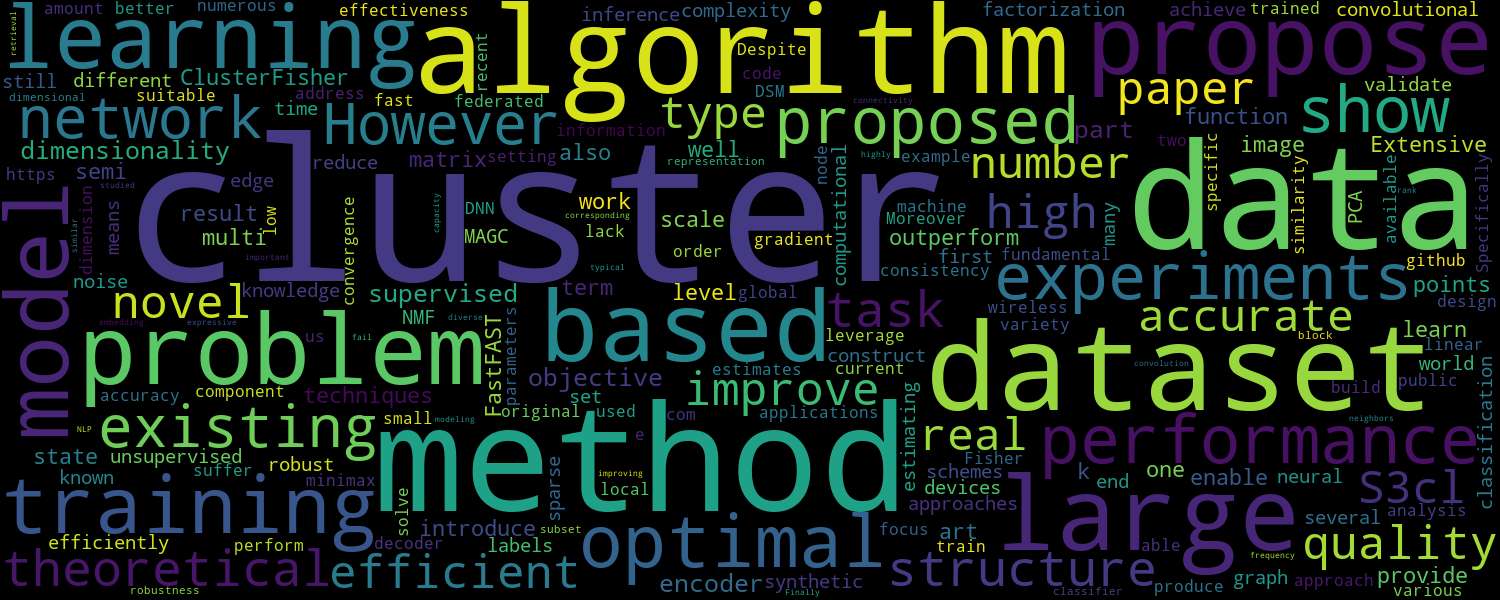

In [ ]:
generateWordCloud("clustering", 10, text_generator)

100%|██████████| 10/10 [01:04<00:00,  6.40s/it]



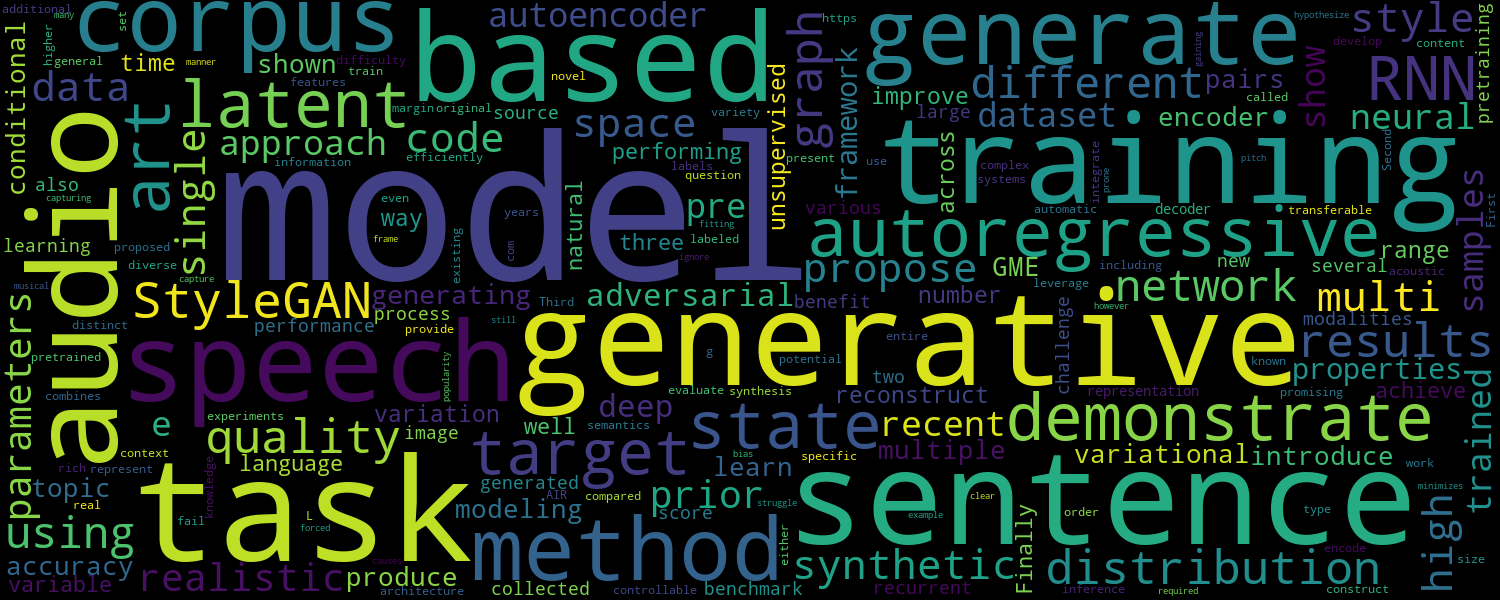

In [ ]:
generateWordCloud("tranformers for text generation", 10, text_generator)

100%|██████████| 10/10 [00:48<00:00,  4.87s/it]



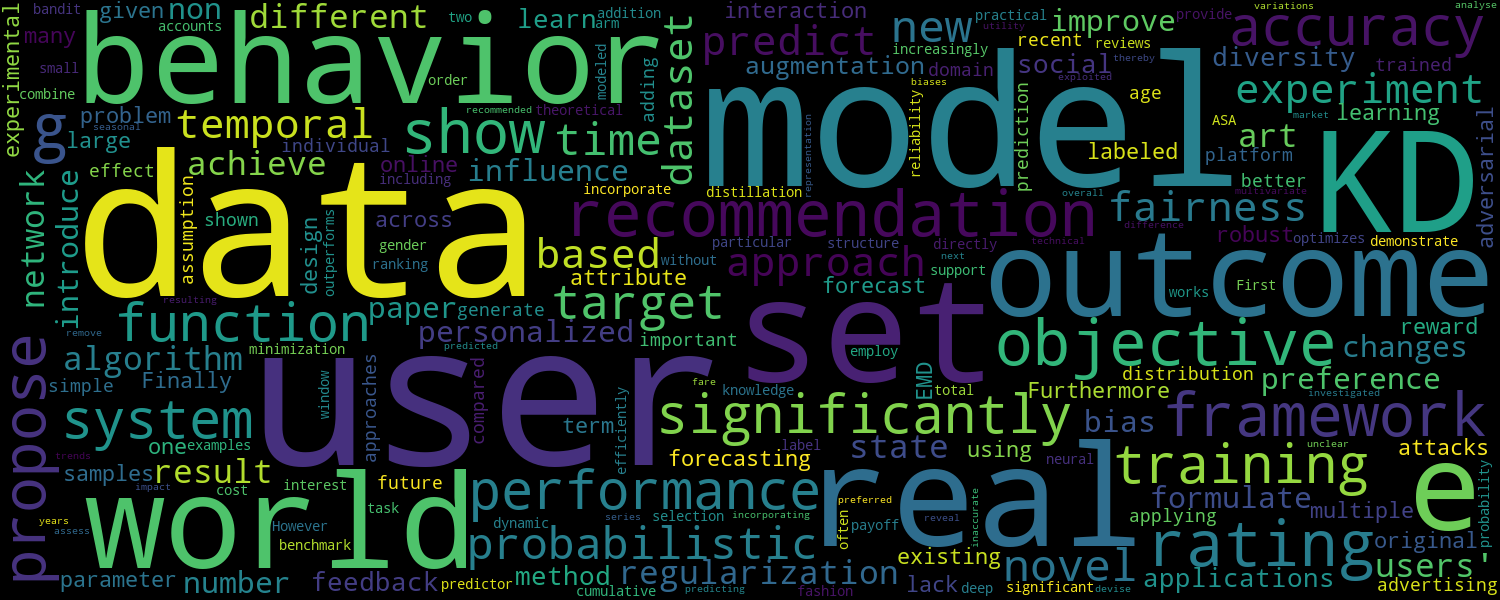

In [ ]:
generateWordCloud("the role of recommender systems", 10, text_generator)

In [ ]:
# Wordcloud using matplotlib
def generateWordCloud(prompt, numOfSamples, text_generator):
    texts=[]
    for x in tqdm(range(numOfSamples)):
        texts.append(text_generator(prompt)[0]["generated_text"].replace("\n", ""))
    texts = pd.Series(texts).str.cat(sep=' ')
    wordcloud = WordCloud(collocations=False, 
                                width=1500, 
                                height=600, 
                                max_font_size=200
                            ).generate(texts)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Accent"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most frequent words in the " +str(numOfSamples)+ " AI-generated text samples. Prompt: "+ prompt +"", size=20, pad=40)
    plt.show()